In [3]:
!pip install torchinfo --q
from PIL import Image  
import matplotlib  
import matplotlib.pyplot as plt  
import matplotlib.patches as mpatches  
import warnings
import torch  
from torch import nn  
from torch import optim  
import torch.optim as optim  
import torch.nn.functional as F  
from torchvision import transforms, models  
from torch.autograd import Variable  
from torchvision.datasets import ImageFolder  
import torch.utils.data as data  
from torch.utils.data import DataLoader, TensorDataset  
import os


device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [4]:
import os
data_dir = '/kaggle/input/wec-intelligence-sig-2024-recruitment-task-cv'
os.listdir(data_dir)

['sample_submission.csv', 'train_images', 'test_images']

In [37]:
average  = torch.Tensor([0,0,0])
standard_dev = torch.Tensor([0,0,0])
images = ImageFolder(data_dir, transforms.ToTensor())
for image in images:
    average += image[0].mean([1,2])
    standard_dev += image[0].std([1,2])
average / len(images) , standard_dev / len(images)

In [5]:
stats = ((0.5207, 0.4255, 0.3801),(0.2521, 0.2265, 0.2231))

In [6]:
train_dir = '/kaggle/input/wec-intelligence-sig-2024-recruitment-task-cv/train_images/train_images'

class_names = os.listdir(train_dir)
class_names

['real_train', 'fake_train']

In [7]:
from torchvision.transforms import v2

data_transforms = {
    'train': transforms.Compose([
        v2.Resize(size = (224,224)),
        v2.ToTensor(),
        v2.RandomHorizontalFlip(),
        transforms.Normalize(*stats,inplace = True),
    
    ]),  

}

train_data = ImageFolder(root=train_dir,
                            transform=data_transforms['train'],
                            target_transform=None,
                            is_valid_file=None)

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [8]:
class_names = train_data.classes
image , label = train_data[169]
image.shape , label

(torch.Size([3, 224, 224]), 0)

In [9]:
class_names

['fake_train', 'real_train']

Text(0.5, 1.0, 'fake_train : 0')

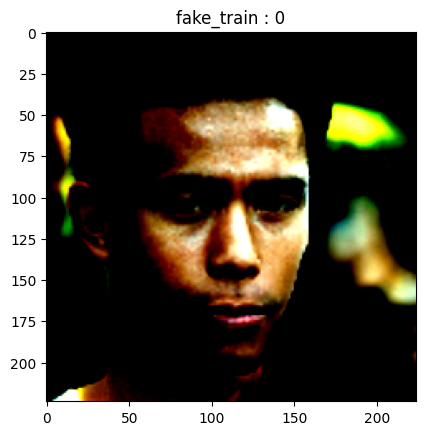

In [10]:
plt.imshow(image.permute(1, 2, 0))
plt.title(f'{class_names[label]} : {label}')

In [11]:
len(train_data)

1600

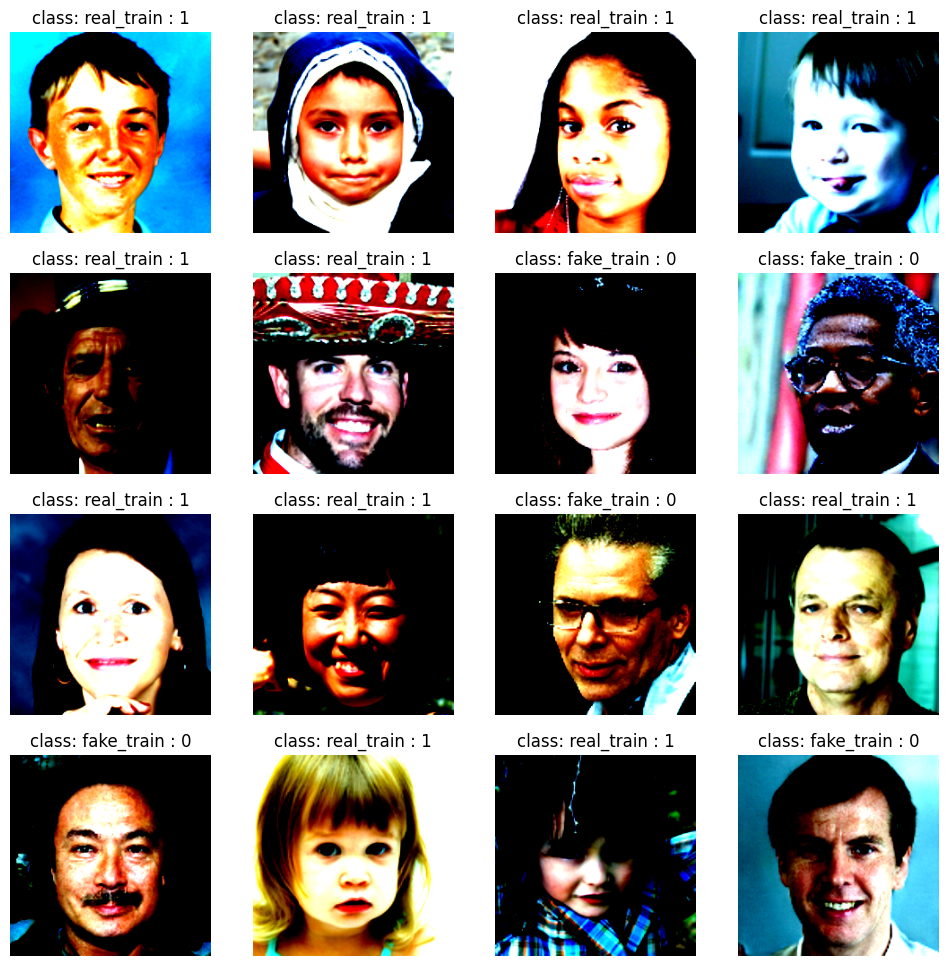

In [12]:
import random
import torch
import matplotlib.pyplot as plt

def plot_random_images(dataset:torch.utils.data.dataset.Dataset ,
                          class_names : list[str] = None,
                          n : int = 3,
                          seed : int = None)->None:
    if seed:
        random.seed(seed)

    fig = plt.figure(figsize=(12, 12))
    for i in range(1,n*n+1):
        random_idx = torch.randint(0 , len(dataset), size = [1]).item()
        image, target = dataset[random_idx]
        fig.add_subplot(n,n,i)
        plt.imshow(image.permute(1,2,0))
        plt.axis(False);
        if class_names:
            title = f"class: {class_names[target]} : {target}"
        else:
            title = None
        plt.title(title)
        
plot_random_images(dataset = train_data, n = 4 , class_names = class_names )

In [13]:
from torch.utils.data import random_split
val_size = int(0.1*len(train_data))
train_size = len(train_data) - val_size

train_data, val_data = random_split(train_data, [train_size, val_size])
len(train_data), len(val_data)

(1440, 160)

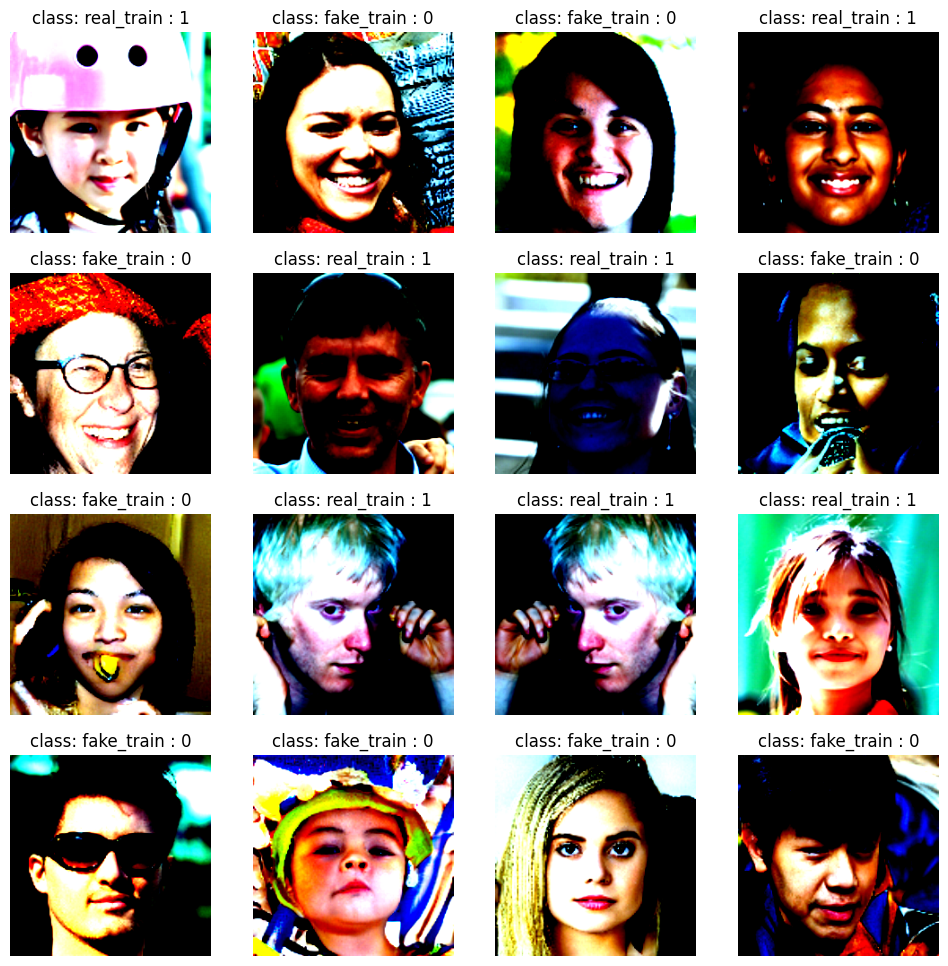

In [14]:
plot_random_images(dataset = val_data, n = 4 , class_names = class_names )

In [15]:
from torch.utils.data import DataLoader
NUM_WORKERS = os.cpu_count()
BATCH_SIZE = 16
NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(
    dataset = train_data,
    batch_size = BATCH_SIZE,
    num_workers = NUM_WORKERS,
    shuffle = True,
)

val_dataloader = DataLoader(
    dataset = val_data,
    batch_size = BATCH_SIZE,
    num_workers = NUM_WORKERS,
    shuffle = False
)

In [42]:
import torch
import torch.nn as nn

class AlexNet224(nn.Module):
    def __init__(self,num_classes = 1000):
        super(AlexNet224, self).__init__()
        self.num_classes = num_classes

        self.ConvBlock1 = nn.Sequential(
            nn.Conv2d(in_channels=3 , out_channels=96 , kernel_size=(11,11) , padding=1 , stride=4, bias = False),
            nn.LeakyReLU(0.2 , inplace=True),
            nn.MaxPool2d(kernel_size=(2,2)  ,stride=2),
            nn.BatchNorm2d(96)
        )

        self.ConvBlock2 = nn.Sequential(
            nn.Conv2d(in_channels=96 , out_channels=256 , kernel_size=(7,7) , padding=3 , stride=1, bias = False),
            nn.LeakyReLU(0.2 , inplace=True),
            nn.MaxPool2d(kernel_size=(3,3)  ,stride=2),
            nn.BatchNorm2d(256)
        )

        self.ConvBlock3 = nn.Sequential(
            nn.Conv2d(in_channels=256 , out_channels=384 , kernel_size=(5,5) , padding=2 , stride=1),
            nn.LeakyReLU(0.2 , inplace=True),
            nn.BatchNorm2d(384)
        )

        self.ConvBlock4 = nn.Sequential(
            nn.Conv2d(in_channels=384 , out_channels= 384 , kernel_size=(3,3) , padding=1 , stride=1),
            nn.LeakyReLU(0.2 , inplace=True),
        )

        self.ConvBlock5 = nn.Sequential(
            nn.Conv2d(in_channels=384 , out_channels=256 , kernel_size=(3,3) , padding=1 , stride=1),
            nn.LeakyReLU(0.2 , inplace=True),
            nn.MaxPool2d(kernel_size=(3,3)  ,stride=2),
        )

        self.FC = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(in_features=256*6*6 , out_features=4096),
            nn.LeakyReLU(0.2 , inplace=True),
            nn.Dropout(0.5),
            nn.Linear(in_features=4096 , out_features=4096),
            nn.LeakyReLU(0.3 , inplace=True),
            nn.Linear(in_features=4096 , out_features=self.num_classes)
        )

    def forward(self,x):
        x = self.ConvBlock1(x)
        x = self.ConvBlock2(x)
        x = self.ConvBlock3(x)
        x = self.ConvBlock4(x)
        x = self.ConvBlock5(x)
        x = self.FC(x)
        return x
    
model = AlexNet224(num_classes = len(class_names)).to(device)
model

AlexNet224(
  (ConvBlock1): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (ConvBlock2): Sequential(
    (0): Conv2d(96, 256, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (ConvBlock3): Sequential(
    (0): Conv2d(256, 384, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (ConvBlock4): Sequential(
    (

In [43]:
from torchinfo import summary
summary(model, (1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
AlexNet224                               [1, 2]                    --
├─Sequential: 1-1                        [1, 96, 27, 27]           --
│    └─Conv2d: 2-1                       [1, 96, 54, 54]           34,848
│    └─LeakyReLU: 2-2                    [1, 96, 54, 54]           --
│    └─MaxPool2d: 2-3                    [1, 96, 27, 27]           --
│    └─BatchNorm2d: 2-4                  [1, 96, 27, 27]           192
├─Sequential: 1-2                        [1, 256, 13, 13]          --
│    └─Conv2d: 2-5                       [1, 256, 27, 27]          1,204,224
│    └─LeakyReLU: 2-6                    [1, 256, 27, 27]          --
│    └─MaxPool2d: 2-7                    [1, 256, 13, 13]          --
│    └─BatchNorm2d: 2-8                  [1, 256, 13, 13]          512
├─Sequential: 1-3                        [1, 384, 13, 13]          --
│    └─Conv2d: 2-9                       [1, 384, 13, 13]          2,457

In [44]:
def train(model:torch.nn.Module,
          train_loader:torch.utils.data.DataLoader,
          optimizer:torch.optim.Optimizer,
          criterion:torch.nn.Module,
          device = device):
    
    # Set the model to training mode
    model.train()

    # Iterate through batches of data in the train_loader
    for batch_idx, (data, target) in enumerate(train_loader):
        # Move data and target tensors to the appropriate device (GPU if available, otherwise CPU)
        data, target = data.to(device), target.to(device)

        # Clear the gradients of all optimized variables
        optimizer.zero_grad()

        # Forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)

        # Calculate the batch loss
        loss =  criterion(output, target)

        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()

        # Perform a single optimization step (parameter update)
        optimizer.step()

In [45]:
def evaluate(model:torch.nn.Module,
              test_loader:torch.utils.data.DataLoader,
              criterion:torch.nn.Module,
              device = device):
    
    # Set the model to evaluation mode
    model.eval()

    # Initialize variables for test loss and correct predictions
    test_loss = 0
    correct = 0

    # Turn off gradients during evaluation
    with torch.no_grad():
        # Iterate through batches of data in the test_loader
        for data, target in test_loader:
            # Move data and target tensors to the appropriate device (GPU if available, otherwise CPU)
            data, target = data.to(device), target.to(device)

            # Forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)

            # Compute the total test loss
            test_loss += criterion(output, target).item()

            # Get the index of the highest probability prediction
            pred = output.max(1, keepdim=True)[1]

            # Count the number of correct predictions
            correct += pred.eq(target.view_as(pred)).sum().item()

    # Calculate the average test loss
    test_loss /= len(test_loader.dataset)

    # Calculate the test accuracy
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [46]:
import time  
import copy  

results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": [],
    }

def train_model(model:torch.nn.Module,
                train_loader:torch.utils.data.DataLoader,
                val_loader:torch.utils.data.DataLoader,
                optimizer:torch.optim.Optimizer,
                criterion:torch.nn.Module , 
                num_epochs:int,
                device:torch.device = device):
    
    
    # Lists to store training and validation accuracies and losses for each epoch

    best_acc = 0.0  # Best validation accuracy initialized to 0.0
    best_model_wts = copy.deepcopy(model.state_dict())  # Deep copy of model weights as the best model

    # Loop through each epoch
    for epoch in range(1, num_epochs + 1):
        since = time.time()  # Record the start time of the epoch

        # Train the model for one epoch
        train(model, train_loader, optimizer , criterion)

        # Evaluate the model on the training and validation sets to get loss and accuracy
        train_loss, train_acc = evaluate(model, train_loader , criterion)
        val_loss, val_acc = evaluate(model, val_loader, criterion)

        # Update the best validation accuracy and best model weights if the current validation accuracy is higher
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())

        # Append current epoch's accuracy and loss values to the lists
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(val_loss)
        results["test_acc"].append(val_acc)

        time_elapsed = time.time() - since  # Calculate time elapsed for the epoch

        # Print epoch statistics
        print('-------------- EPOCH {} ----------------'.format(epoch))
        print('Train Loss: {:.4f}, Accuracy: {:.2f}%'.format(train_loss, train_acc))
        print('Val Loss: {:.4f}, Accuracy: {:.2f}%'.format(val_loss, val_acc))
        print('Time: {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        print()

    # Load the best model weights
    model.load_state_dict(best_model_wts)

    # Return the model with the best weights
    return model

In [47]:
epoch = 25
learning_rate = 0.0001

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

model = train_model(model, train_dataloader, val_dataloader, optimizer, criterion ,epoch)

-------------- EPOCH 1 ----------------
Train Loss: 0.0455, Accuracy: 49.10%
Val Loss: 0.0442, Accuracy: 51.25%
Time: 0m 7s

-------------- EPOCH 2 ----------------
Train Loss: 0.0430, Accuracy: 53.47%
Val Loss: 0.0439, Accuracy: 49.38%
Time: 0m 7s

-------------- EPOCH 3 ----------------
Train Loss: 0.0443, Accuracy: 51.81%
Val Loss: 0.0478, Accuracy: 46.25%
Time: 0m 6s

-------------- EPOCH 4 ----------------
Train Loss: 0.0431, Accuracy: 54.03%
Val Loss: 0.0429, Accuracy: 48.12%
Time: 0m 7s

-------------- EPOCH 5 ----------------
Train Loss: 0.0433, Accuracy: 53.47%
Val Loss: 0.0424, Accuracy: 57.50%
Time: 0m 7s

-------------- EPOCH 6 ----------------
Train Loss: 0.0416, Accuracy: 60.42%
Val Loss: 0.0430, Accuracy: 56.25%
Time: 0m 6s

-------------- EPOCH 7 ----------------
Train Loss: 0.0426, Accuracy: 56.04%
Val Loss: 0.0443, Accuracy: 46.25%
Time: 0m 6s

-------------- EPOCH 8 ----------------
Train Loss: 0.0418, Accuracy: 60.83%
Val Loss: 0.0412, Accuracy: 67.50%
Time: 0m 7s



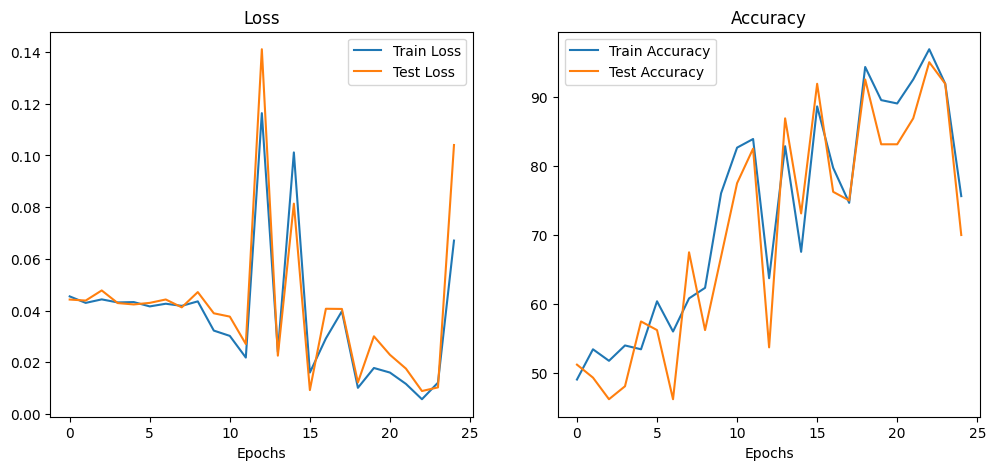

In [48]:
def plot_loss_curves(results: dict[str, list[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='Train Loss')
    plt.plot(epochs, test_loss, label='Test Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='Train Accuracy')
    plt.plot(epochs, test_accuracy, label='Test Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();
             
plot_loss_curves(results)

In [49]:
model.eval()

_, train_acc = evaluate(model, train_dataloader , criterion)

_, val_acc = evaluate(model, val_dataloader , criterion)


print('Train Accuracy: {:.4f}%'.format(train_acc))
print('Validation Accuracy: {:.4f}%'.format(val_acc))

Train Accuracy: 96.9444%
Validation Accuracy: 96.2500%


In [52]:
def make_predictions(model: torch.nn.Module,
                     data: list, 
                     device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            
            sample = torch.unsqueeze(sample, dim=0).to(device) 

            pred_logit = model(sample)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0) 
            pred_probs.append(pred_prob.cpu())

    return torch.stack(pred_probs)

import random
test_samples = []
test_labels = []
for sample, label in random.sample(list(val_data), k=16):
    test_samples.append(sample)
    test_labels.append(label)

pred_probs= make_predictions(model=model,
                             data=test_samples)

pred_classes = pred_probs.argmax(dim=1)
pred_classes

test_labels, pred_classes

([1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1],
 tensor([1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1]))

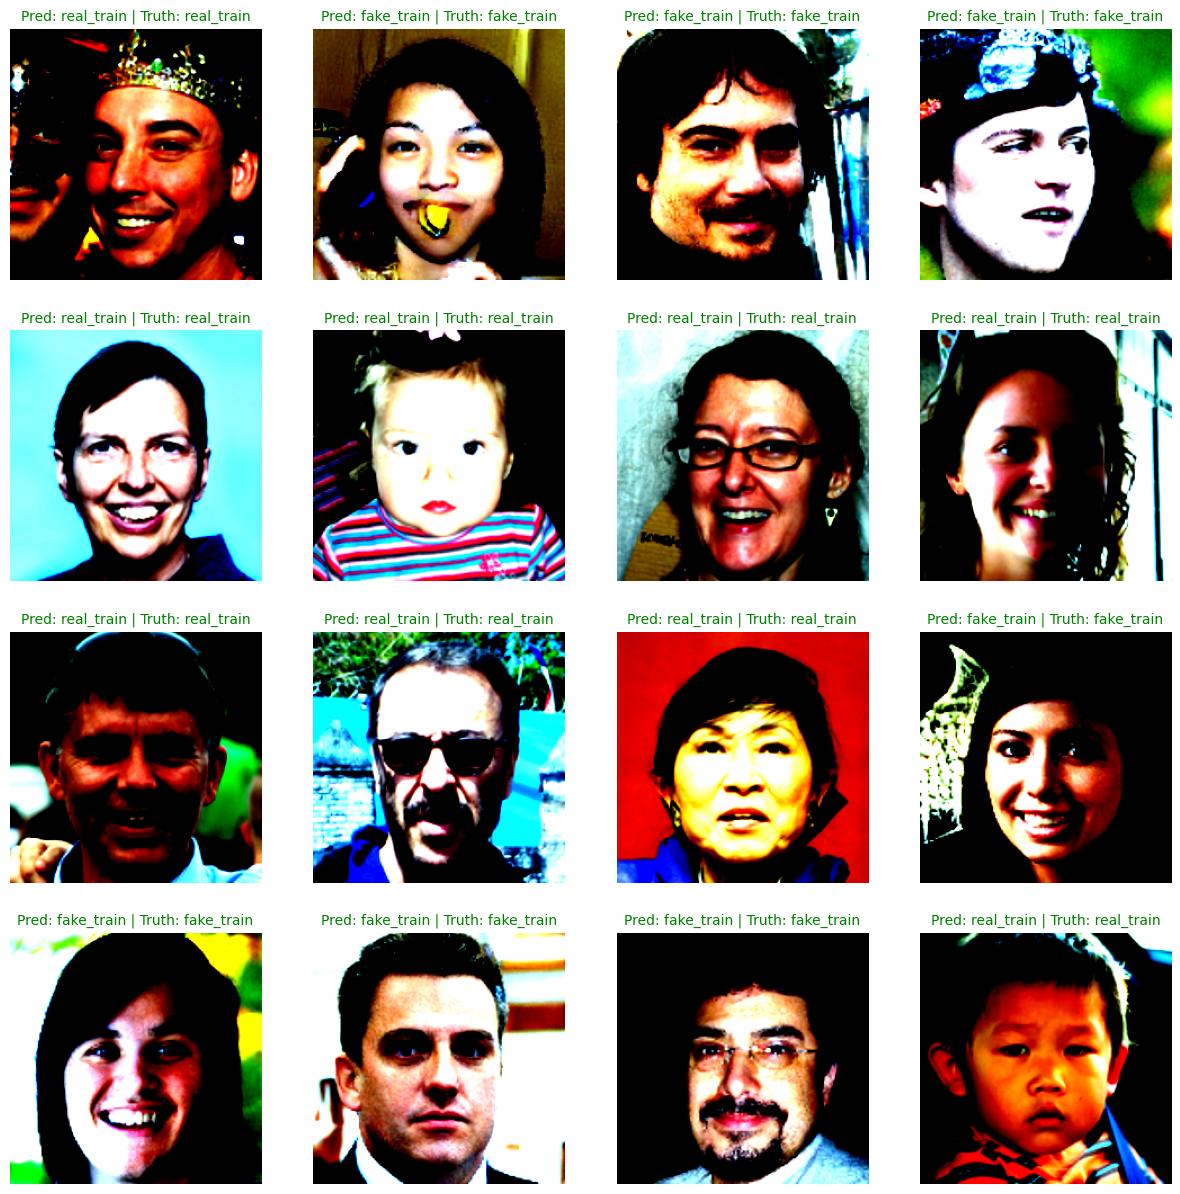

In [53]:
def plot_predicted_images(samples : list ,
                          test_targets : torch.Tensor ,
                          test_preds : torch.Tensor, 
                          class_names : list,
                          rows : int = 4,
                          cols : int = 4):
    
    plt.figure(figsize=(15, 15))
    for i, sample in enumerate(samples):
      plt.subplot(rows, cols, i+1)
      plt.imshow(sample.permute(1,2,0), cmap="gray")
      pred_label = class_names[test_preds[i]]
      truth_label = class_names[test_targets[i]]

      title_text = f"Pred: {pred_label} | Truth: {truth_label}"
      if pred_label == truth_label:
          plt.title(title_text, fontsize=10, c="g") 
      else:
          plt.title(title_text, fontsize=10, c="r") 
      plt.axis(False);
    
plot_predicted_images(test_samples, test_labels , pred_classes , class_names )

In [54]:
def get_preds(model , dataloader , device = device):
    from tqdm.auto import tqdm
    y_preds = []
    with torch.inference_mode():
        for X, y in tqdm(dataloader, desc="Making predictions"):

            X, y = X.to(device), y.to(device)

            y_logit = model(X)

            y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)

            y_preds.append(y_pred.cpu())

    y_pred_tensor = torch.cat(y_preds)
    return y_pred_tensor

val_preds = get_preds(model , val_dataloader)

len(val_preds)

Making predictions:   0%|          | 0/10 [00:00<?, ?it/s]

160

In [55]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

val_targets = [label for image , label  in val_data]

print(f'Validation Accuarcy : {accuracy_score(val_targets, val_preds)*100}%')
print(f'Validation F1 Score : {f1_score(val_targets, val_preds)}%')

Validation Accuarcy : 97.5%
Validation F1 Score : 0.972972972972973%


In [56]:
data_transforms = {
 
    'test': transforms.Compose([
        v2.Resize(size = (224,224)),
        v2.ToTensor(),
        v2.RandomHorizontalFlip(p=0.5),
        transforms.Normalize(*stats,inplace = True),
    
    ]) ,
     
}

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [57]:
test_dir = "/kaggle/input/wec-intelligence-sig-2024-recruitment-task-cv/test_images/"
test_data = ImageFolder(root=test_dir,
                          transform=data_transforms['test'],
                          target_transform=None,
                          is_valid_file=None)

In [58]:
len(test_data)

400

In [59]:
image , label = test_data[1]
image.shape , label

(torch.Size([3, 224, 224]), 0)

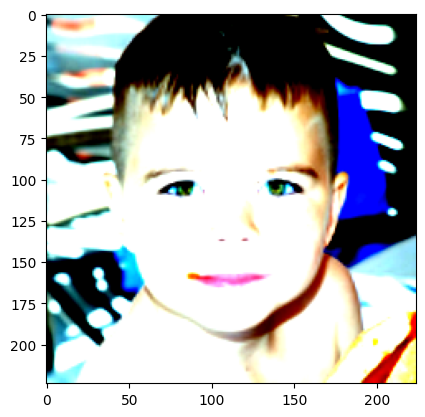

In [60]:
plt.imshow(image.permute(1,2,0))

In [62]:
test_dataloader = DataLoader(
    dataset = test_data,
    batch_size = BATCH_SIZE,
    num_workers = NUM_WORKERS,
    shuffle = False
)

In [64]:
test_preds = get_preds(model , test_dataloader)

Making predictions:   0%|          | 0/25 [00:00<?, ?it/s]

In [65]:
import pandas as pd
submission_df = pd.read_csv("/kaggle/input/wec-intelligence-sig-2024-recruitment-task-cv/sample_submission.csv")

In [66]:
submission_df["TARGET"] = test_preds

In [67]:
test_preds

tensor([1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0,
        1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0,
        0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
        0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0,
        0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1,
        1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1,
        0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0,
        0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0,
        1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
        1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1,
        1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
        1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,

In [68]:
submission_df.to_csv("submission_4.csv")